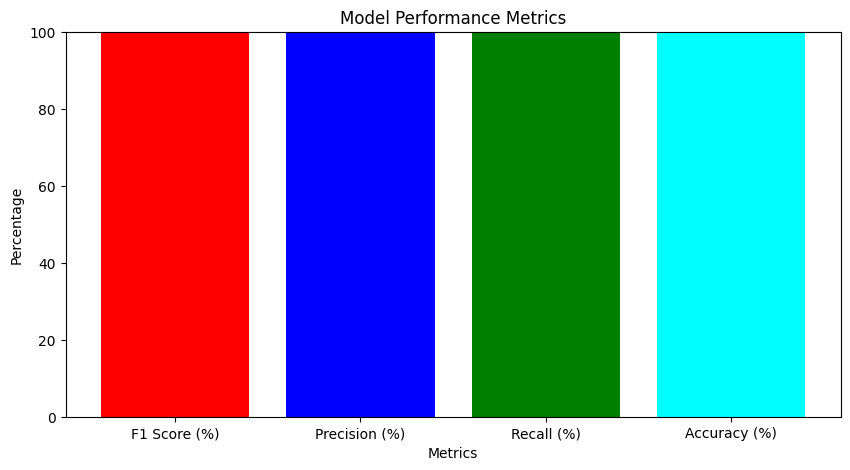

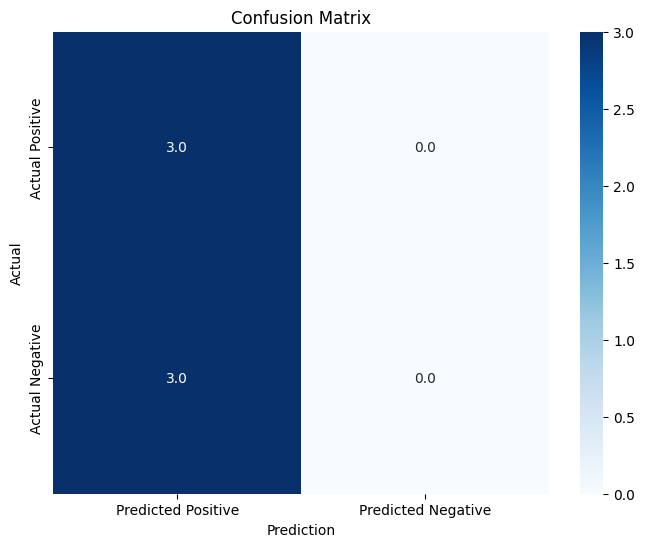

In [5]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def calculate_metrics(outputs, labels):
    preds = (outputs > 0.5).float()
    
    true_positives = (preds * labels).sum(dim=0).float()
    false_positives = ((preds == 1) & (labels == 0)).sum(dim=0).float()
    false_negatives = ((preds == 0) & (labels == 1)).sum(dim=0).float()
    true_negatives = ((preds == 0) & (labels == 0)).sum(dim=0).float()
    
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-8)
    
    precision_mean = (precision.mean().item() * 100)
    recall_mean = (recall.mean().item() * 100)
    f1_score_mean = (f1_scores.mean().item() * 100)
    accuracy_mean = (accuracy.mean().item() * 100)
    
    total_samples = labels.numel()  # 전체 샘플 수 계산
    
    confusion_matrix = {
        'True Positives': true_positives.sum().item(),
        'False Positives': false_positives.sum().item(),
        'True Negatives': true_negatives.sum().item(),
        'False Negatives': false_negatives.sum().item()
    }
    
    metrics = {
        'F1 Score (%)': f1_score_mean,
        'Precision (%)': precision_mean,
        'Recall (%)': recall_mean,
        'Accuracy (%)': accuracy_mean,
        'Confusion Matrix': confusion_matrix
    }
    
    return metrics

def plot_metrics(metrics):
    # 성능 지표 시각화
    metrics_names = ['F1 Score (%)', 'Precision (%)', 'Recall (%)', 'Accuracy (%)']
    metrics_values = [metrics[name] for name in metrics_names]

    plt.figure(figsize=(10, 5))
    plt.bar(metrics_names, metrics_values, color=['red', 'blue', 'green', 'cyan'])
    plt.ylim(0, 100)
    plt.xlabel('Metrics')
    plt.ylabel('Percentage')
    plt.title('Model Performance Metrics')
    plt.show()
    
    # 혼동 행렬 시각화
    confusion_matrix = metrics['Confusion Matrix']
    cm_labels = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
    cm_values = [confusion_matrix[label] for label in cm_labels]

    cm_array = np.array(cm_values).reshape(2, 2)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_array, annot=True, fmt=".1f", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'], yticklabels=['Actual Positive', 'Actual Negative'])
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# 예제 사용
outputs = torch.tensor([[0.6, 0.4, 0.8], [0.2, 0.9, 0.1]])
labels = torch.tensor([[1, 0, 1], [0, 1, 0]])

metrics = calculate_metrics(outputs, labels)
plot_metrics(metrics)


In [12]:
def create_image_paths(df, column_name, base_path='../cut_datas'):
    df['Image Path'] = df[column_name].apply(lambda x: os.path.join(base_path, f'{x}.jpg'))
    return df

In [11]:
# 데이터프레임 로드
df_raw = pd.read_csv('multi_label_dataset_cut.csv')
df = df_raw.copy()
df = df.drop(['Image Filename', 'None'], axis=1)

# 이미지 경로 생성
df = create_image_paths(df, 'Image ID')
df = df.drop(['Unnamed: 0', 'Image ID'], axis=1)
df = df.drop(['Unnamed: 0.1'], axis=1)
#물흐리는 스트리트 삭제
df = df.drop(['스트리트'], axis=1)

df.to_csv('cut_image_labeling_dataset.csv')

NameError: name 'create_image_paths' is not defined

In [13]:
df = pd.read_csv('cut_image_labeling_dataset.csv')
df

,Unnamed: 0,페미닌,로맨틱,리조트,모던,스포티,톰보이,매니시,젠더리스,Image Path
0,0,1,0,0,0,0,0,0,0,../cut_datas\1000.jpg
1,1,0,1,0,0,0,0,0,0,../cut_datas\100026.jpg
2,2,0,1,0,0,0,0,0,0,../cut_datas\100027.jpg
3,3,0,1,0,0,0,0,0,0,../cut_datas\100029.jpg
4,4,0,1,0,0,0,0,0,0,../cut_datas\1000316.jpg
...,...,...,...,...,...,...,...,...,...,...
152459,152459,0,0,0,0,0,0,1,0,../cut_datas\999747.jpg
152460,152460,0,0,0,0,0,1,0,0,../cut_datas\999756.jpg
152461,152461,0,0,0,0,0,1,0,0,../cut_datas\999761.jpg
152462,152462,0,0,0,0,0,1,0,0,../cut_datas\999762.jpg


In [14]:
import torch
from torchvision import models
import torch.nn as nn

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 정의 및 로드
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.4),
    nn.Linear(256, 8)  # 클래스 수에 맞게 수정
)
model.load_state_dict(torch.load('val_acc_best_model_v7.pth'))
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# 데이터셋 클래스 정의
class ClothesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.image_paths = df['Image Path'].to_numpy()
        self.labels = df.iloc[:, 1:-1].to_numpy()
        print(f'Labels shape: {self.labels.shape}')
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        
        print(f"Loaded image: {img_path}")
        return image, torch.tensor(label, dtype=torch.float32)

def collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        print("No valid items in batch")
        return torch.Tensor(), torch.Tensor()
    return torch.utils.data.dataloader.default_collate(batch)

# 데이터프레임 로드 및 샘플링
df = pd.read_csv('cut_image_labeling_dataset.csv')
df_sampled = df.sample(n=500, random_state=42).reset_index(drop=True)

# 데이터셋 및 데이터로더 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = ClothesDataset(df_sampled, transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)


Labels shape: (500, 8)


In [25]:
import numpy as np

def calculate_f1_score(outputs, labels):
    preds = (outputs > 0.5).float()
    
    true_positives = (preds * labels).sum(dim=0).float()
    false_positives = ((preds == 1) & (labels == 0)).sum(dim=0).float()
    false_negatives = ((preds == 0) & (labels == 1)).sum(dim=0).float()
    
    precision = true_positives / (true_positives + false_positives + 1e-8)
    recall = true_positives / (true_positives + false_negatives + 1e-8)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    return f1_scores.mean().item() * 100  # F1 스코어의 평균을 퍼센트로 반환


Loaded image: ../cut_datas\275972.jpg
Loaded image: ../cut_datas\1130576.jpg
Loaded image: ../cut_datas\1074011.jpg
Loaded image: ../cut_datas\238366.jpg
Loaded image: ../cut_datas\468183.jpg
Loaded image: ../cut_datas\686316.jpg
Loaded image: ../cut_datas\1286055.jpg
Loaded image: ../cut_datas\1040335.jpg
Loaded image: ../cut_datas\1211049.jpg
Loaded image: ../cut_datas\1333131.jpg
Loaded image: ../cut_datas\310962.jpg
Loaded image: ../cut_datas\133244.jpg
Loaded image: ../cut_datas\327226.jpg
Loaded image: ../cut_datas\343681.jpg
Loaded image: ../cut_datas\197966.jpg
Loaded image: ../cut_datas\305802.jpg
Loaded image: ../cut_datas\121501.jpg
Loaded image: ../cut_datas\242964.jpg
Loaded image: ../cut_datas\108671.jpg
Loaded image: ../cut_datas\506372.jpg
Loaded image: ../cut_datas\1204860.jpg
Loaded image: ../cut_datas\167110.jpg
Loaded image: ../cut_datas\326475.jpg
Loaded image: ../cut_datas\487105.jpg
Loaded image: ../cut_datas\111324.jpg
Loaded image: ../cut_datas\34030.jpg
Loaded

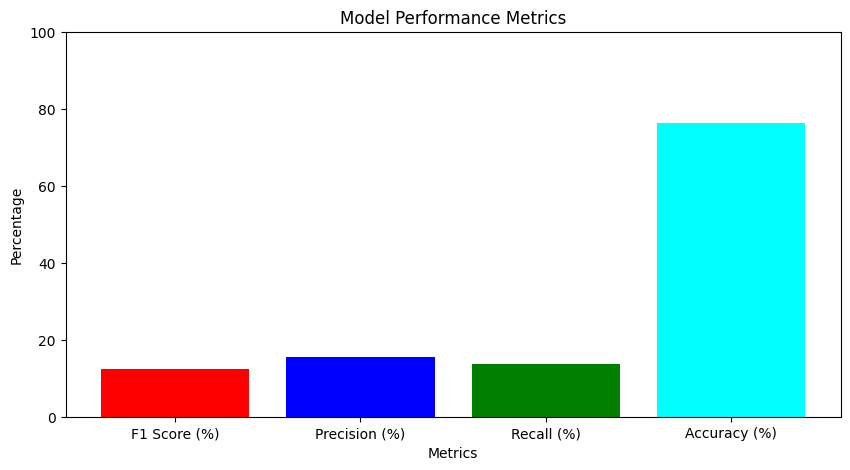

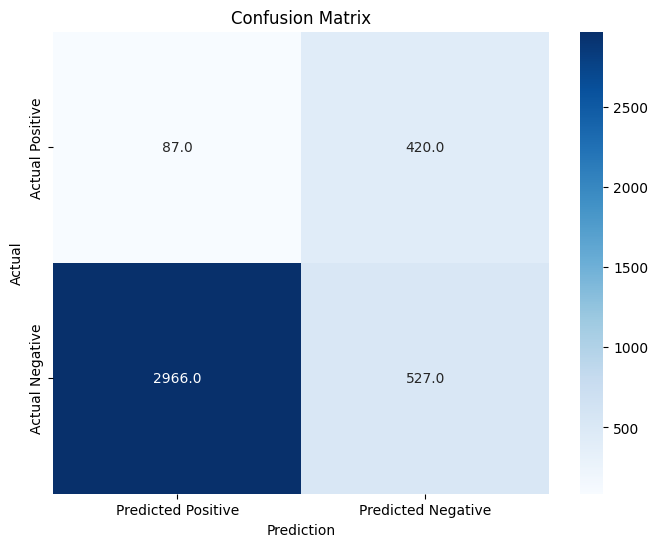

In [29]:
# 모델 평가 및 F1 스코어 계산
all_outputs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        all_outputs.append(outputs.cpu())
        all_labels.append(labels.cpu())

all_outputs = torch.cat(all_outputs)
all_labels = torch.cat(all_labels)
metrics = calculate_metrics(all_outputs, all_labels)
plot_metrics(metrics)
